# Negative L1 norm prior experiment

This code attempts to learn the 32D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 22717.701171875
iteration 0 loss 12900.173828125


iteration 5000 loss 61.936256408691406


iteration 10000 loss 4.837813854217529


iteration 15000 loss 1.845622181892395


iteration 20000 loss 1.3407549858093262


iteration 25000 loss 1.0964077711105347


iteration 30000 loss 0.9731396436691284


iteration 35000 loss 0.8686527013778687


iteration 40000 loss 0.806603729724884


iteration 45000 loss 0.7477924227714539


iteration 50000 loss 0.7000167965888977


iteration 55000 loss 0.6616070866584778


iteration 60000 loss 0.622046947479248


iteration 65000 loss 0.5947896242141724


iteration 70000 loss 0.5699328184127808


iteration 75000 loss 0.5475454926490784


iteration 80000 loss 0.5288751125335693


iteration 85000 loss 0.5112707018852234


iteration 90000 loss 0.49375417828559875


iteration 95000 loss 0.47953298687934875


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.4667258560657501


iteration 105000 loss 0.4626757800579071


iteration 110000 loss 0.4500039517879486


iteration 115000 loss 0.43661385774612427


iteration 120000 loss 0.42494285106658936


iteration 125000 loss 0.4125325083732605


iteration 130000 loss 0.40238475799560547


iteration 135000 loss 0.3909662067890167


iteration 140000 loss 0.3794216215610504


iteration 145000 loss 0.3700229525566101


iteration 150000 loss 0.36032140254974365


iteration 155000 loss 0.35070258378982544


iteration 160000 loss 0.3421844244003296


iteration 165000 loss 0.33222144842147827


iteration 170000 loss 0.323903888463974


iteration 175000 loss 0.3145257830619812


iteration 180000 loss 0.3076489269733429


iteration 185000 loss 0.3003523349761963


iteration 190000 loss 0.291404664516449


iteration 195000 loss 0.28494712710380554


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.27820244431495667


iteration 205000 loss 0.2755068838596344


iteration 210000 loss 0.2672460377216339


iteration 215000 loss 0.25936657190322876


iteration 220000 loss 0.2519468069076538


iteration 225000 loss 0.24490498006343842


iteration 230000 loss 0.23819564282894135


iteration 235000 loss 0.23176908493041992


iteration 240000 loss 0.22556789219379425


iteration 245000 loss 0.21961498260498047


iteration 250000 loss 0.21386577188968658


iteration 255000 loss 0.20836281776428223


iteration 260000 loss 0.2030646651983261


iteration 265000 loss 0.19796600937843323


iteration 270000 loss 0.19309833645820618


iteration 275000 loss 0.18845537304878235


iteration 280000 loss 0.1840529441833496


iteration 285000 loss 0.17983205616474152


iteration 290000 loss 0.1757911592721939


iteration 295000 loss 0.1719224750995636


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.168233260512352


iteration 305000 loss 0.16764476895332336


iteration 310000 loss 0.1669238954782486


iteration 315000 loss 0.16623236238956451


iteration 320000 loss 0.16555888950824738


iteration 325000 loss 0.16489917039871216


iteration 330000 loss 0.16425089538097382


iteration 335000 loss 0.16361260414123535


iteration 340000 loss 0.1629832684993744


iteration 345000 loss 0.16236183047294617


iteration 350000 loss 0.16174787282943726


iteration 355000 loss 0.1611408293247223


iteration 360000 loss 0.16054095327854156


iteration 365000 loss 0.15994736552238464


iteration 370000 loss 0.15935958921909332


iteration 375000 loss 0.1587773859500885


iteration 380000 loss 0.15820051729679108


iteration 385000 loss 0.15762899816036224


iteration 390000 loss 0.1570625901222229


iteration 395000 loss 0.15650098025798798


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.15594372153282166


iteration 405000 loss 0.15589770674705505


iteration 410000 loss 0.15585140883922577


iteration 415000 loss 0.15580561757087708


iteration 420000 loss 0.15576015412807465


iteration 425000 loss 0.15571488440036774


iteration 430000 loss 0.1556698977947235


iteration 435000 loss 0.15562507510185242


iteration 440000 loss 0.1555805206298828


iteration 445000 loss 0.15553593635559082


iteration 450000 loss 0.15549176931381226


iteration 455000 loss 0.1554475724697113


iteration 460000 loss 0.15540367364883423


iteration 465000 loss 0.15535980463027954


iteration 470000 loss 0.1553160846233368


iteration 475000 loss 0.15527257323265076


iteration 480000 loss 0.15522904694080353


iteration 485000 loss 0.1551857441663742


iteration 490000 loss 0.15514259040355682


iteration 495000 loss 0.15509945154190063


L2 loss -- Plot

loss 48.410858154296875


loss -45.28474426269531


loss -93.06182861328125


loss -116.890380859375


loss -126.7558364868164


loss -130.20037841796875


loss -131.1900634765625


loss -131.40850830078125


loss -131.44207763671875


loss -131.4452362060547


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.4453887939453


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.4453887939453


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.44540405273438


loss -131.4453887939453


loss -131.44540405273438


final mse:  1.8585536665227664e-08
max, min: 2.0999084 -2.1295438
loss 48.410858154296875


loss -36.31854248046875


loss -65.4696044921875


loss -74.86337280273438


loss -77.38687133789062


loss -77.95278930664062


loss -78.04972839355469


loss -78.06097412109375


loss -78.06175231933594


loss -78.06177520751953


loss -78.06177520751953


loss -78.061767578125


loss -78.061767578125


loss -78.06177520751953


loss -78.061767578125


loss -78.06177520751953


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.06177520751953


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


loss -78.061767578125


final mse:  1.2289841144763614e-08
max, min: 1.4877915 -1.642687


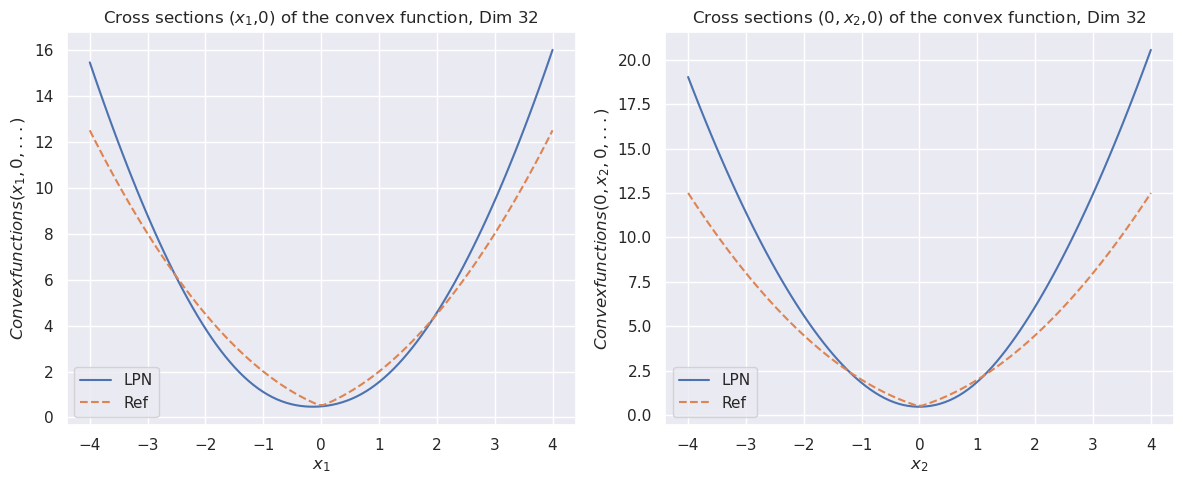

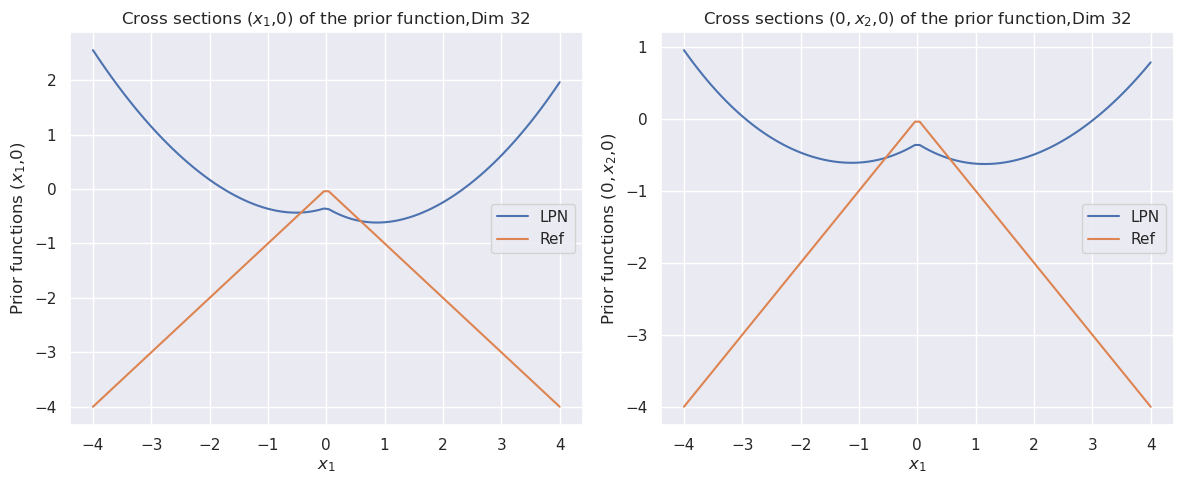

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 8965.8525390625
iteration 0 loss 2195.837890625


iteration 5000 loss 2.7185328006744385


iteration 10000 loss 1.2061771154403687


iteration 15000 loss 0.7623023390769958


iteration 20000 loss 0.6739624738693237


iteration 25000 loss 0.48999401926994324


iteration 30000 loss 0.40915611386299133


iteration 35000 loss 0.3710624873638153


iteration 40000 loss 0.3358319103717804


iteration 45000 loss 0.29615744948387146


iteration 50000 loss 0.26499947905540466


iteration 55000 loss 0.24120600521564484


iteration 60000 loss 0.23269428312778473


iteration 65000 loss 0.20906244218349457


iteration 70000 loss 0.1931297779083252


iteration 75000 loss 0.18283092975616455


iteration 80000 loss 0.1982233077287674


iteration 85000 loss 0.1594618856906891


iteration 90000 loss 0.15058711171150208


iteration 95000 loss 0.14370089769363403


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.13914968073368073


iteration 105000 loss 0.1290186196565628


iteration 110000 loss 0.12218500673770905


iteration 115000 loss 0.11585517227649689


iteration 120000 loss 0.11026706546545029


iteration 125000 loss 0.10517918318510056


iteration 130000 loss 0.10050274431705475


iteration 135000 loss 0.0963011234998703


iteration 140000 loss 0.09267793595790863


iteration 145000 loss 0.08929463475942612


iteration 150000 loss 0.08601973205804825


iteration 155000 loss 0.09285969287157059


iteration 160000 loss 0.08050083369016647


iteration 165000 loss 0.07777179777622223


iteration 170000 loss 0.07529294490814209


iteration 175000 loss 0.07287528365850449


iteration 180000 loss 0.07093577831983566


iteration 185000 loss 0.06895319372415543


iteration 190000 loss 0.06697206944227219


iteration 195000 loss 0.0653986781835556


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.06378589570522308


iteration 205000 loss 0.06334999948740005


iteration 210000 loss 0.06172872334718704


iteration 215000 loss 0.07344640791416168


iteration 220000 loss 0.05857176333665848


iteration 225000 loss 0.05697270482778549


iteration 230000 loss 0.05558377504348755


iteration 235000 loss 0.05434718355536461


iteration 240000 loss 0.05288269370794296


iteration 245000 loss 0.05181245505809784


iteration 250000 loss 0.050444345921278


iteration 255000 loss 0.04942113906145096


iteration 260000 loss 0.0483272448182106


iteration 265000 loss 0.04735855758190155


iteration 270000 loss 0.04645214229822159


iteration 275000 loss 0.04545193910598755


iteration 280000 loss 0.044678136706352234


iteration 285000 loss 0.043766748160123825


iteration 290000 loss 0.04295036569237709


iteration 295000 loss 0.042255036532878876


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.04153269901871681


iteration 305000 loss 0.04115551337599754


iteration 310000 loss 0.03994002193212509


iteration 315000 loss 0.03876820206642151


iteration 320000 loss 0.037657130509614944


iteration 325000 loss 0.03660149872303009


iteration 330000 loss 0.03559333458542824


iteration 335000 loss 0.03462991490960121


iteration 340000 loss 0.033709343522787094


iteration 345000 loss 0.032833803445100784


iteration 350000 loss 0.03200219199061394


iteration 355000 loss 0.031201284378767014


iteration 360000 loss 0.03044179081916809


iteration 365000 loss 0.029709380120038986


iteration 370000 loss 0.029010899364948273


iteration 375000 loss 0.02833792008459568


iteration 380000 loss 0.027691300958395004


iteration 385000 loss 0.027065780013799667


iteration 390000 loss 0.02645944058895111


iteration 395000 loss 0.02587825246155262


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.02532419003546238


iteration 405000 loss 0.025210769847035408


iteration 410000 loss 0.025060027837753296


iteration 415000 loss 0.02491563931107521


iteration 420000 loss 0.024775035679340363


iteration 425000 loss 0.024637378752231598


iteration 430000 loss 0.02450210228562355


iteration 435000 loss 0.024368902668356895


iteration 440000 loss 0.0242374986410141


iteration 445000 loss 0.024107718840241432


iteration 450000 loss 0.023979676887392998


iteration 455000 loss 0.023852959275245667


iteration 460000 loss 0.02372768707573414


iteration 465000 loss 0.023603644222021103


iteration 470000 loss 0.023480795323848724


iteration 475000 loss 0.023359138518571854


iteration 480000 loss 0.023238588124513626


iteration 485000 loss 0.023119065910577774


iteration 490000 loss 0.023000570014119148


iteration 495000 loss 0.02288297936320305


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


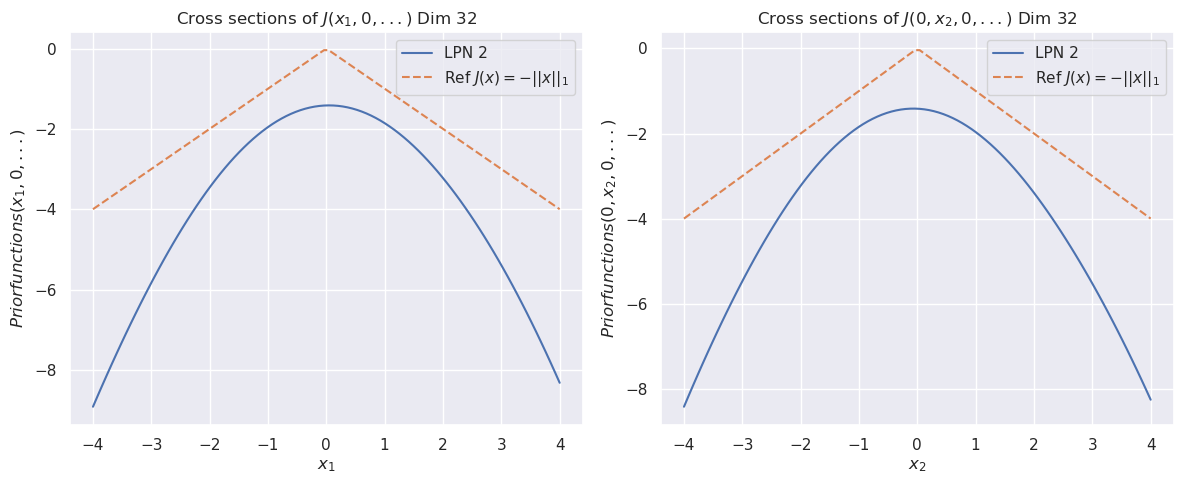

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)